In this notebook I give a very simple (and rather uncommented) example of how to use [scikit-learn]() to perform an Empirical Orthogonal Function decomposition (*EOF analysis*, often referred to as well as *Principal Component Analysis* or *PCA*) of a climate field, in this case the monthly Sea Surface Temperature (SST) anomalies in the Pacific. 
<!-- TEASER_END -->

In [2]:
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm

In [3]:
%matplotlib inline

<br>
A small function to plot a 2D field on a map with [basemap](http://matplotlib.org/basemap/index.html)

In [4]:
def plot_field(m, X, lat, lon, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

<br>
## load the SST data

I am using [xray](https://github.com/xray/xray) for reading / writing netcdf files and manipulating the N-Dimensional labelled arrays 
contained in them, to know more about xray, refer to [my previous blog post](http://nicolasfauchereau.github.io/climatecode/posts/xray/)

In [5]:
import xray

In [6]:
dset = xray.open_dataset('/Users/nicolasf/data/SST/ER_SST/ersst.realtime.nc')

In [7]:
dset

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 800, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-15 1948-03-15 1948-04-15 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * zlev     (zlev) float32 0.0
Data variables:
    err      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    sst      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    anom     (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    source: NOAA/National Climatic Data Center
    history: Sun Oct  5 09:00:07 2014: ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.nc ersst.194811_ft.nc ersst.194812_ft.nc ersst.194901_ft.nc ersst.194902_ft.nc ersst.194903_ft.nc ersst.194904_ft.nc ersst.

<br>
### Selects the period 1950 - 2013 and the tropical Pacific domain

In [8]:
dsub = dset.sel(time=slice('1950','2013'), zlev=0, lat=slice(-40,40), lon=slice(120,290))

In [9]:
lat = dsub['lat'].values
lon = dsub['lon'].values
sst = dsub['anom'].values

In [10]:
lons, lats = np.meshgrid(lon, lat)

In [11]:
sst.shape

(768, 41, 86)

<br>
### reshape in 2D (time, space)

In [12]:
X = np.reshape(sst, (sst.shape[0], len(lat) * len(lon)), order='F')

In [13]:
np.any(np.isnan(X))

True

<br>
### Mask the land points

In [14]:
type(X)

numpy.ndarray

In [15]:
X = ma.masked_array(X, np.isnan(X))

In [16]:
type(X)

numpy.ma.core.MaskedArray

In [17]:
land = X.sum(0).mask

In [18]:
ocean = -land

<br>
### keep only oceanic grid-points

In [19]:
X = X[:,ocean]

<br>
### Standardize SST using the fit and transform methods of the `sklearn.preprocessing.scaler.StandardScaler`

In [20]:
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()

In [21]:
scaler_sst = scaler.fit(X)

<br>
### Once the scaler object has been 'trained' on the data, we can save it as a pickle object

In [22]:
from sklearn.externals import joblib

In [23]:
joblib.dump(scaler_sst, './scaler_sst.pkl', compress=9)

['./scaler_sst.pkl']

In [24]:
scaler_sst = joblib.load('./scaler_sst.pkl')

<br>
### scales: use the `transform` method of the scaler object

In [25]:
X = scaler_sst.transform(X)

<br>
### verify that mean = 0 and std = 1

In [26]:
X.mean()

-8.4161496440623899e-19

In [27]:
X.std()

1.0000000000000002

In [28]:
X.shape

(768, 3133)

<br>
### EOF decomposition 

In [29]:
from sklearn.decomposition import pca

<br>
#### instantiates the PCA object

In [30]:
skpca = pca.PCA()

<br>
#### fit

In [31]:
skpca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

<br>
### Now saves the (fitted) PCA object for reuse in operations

In [32]:
joblib.dump(skpca, '../EOF.pkl', compress=9)

['../EOF.pkl']

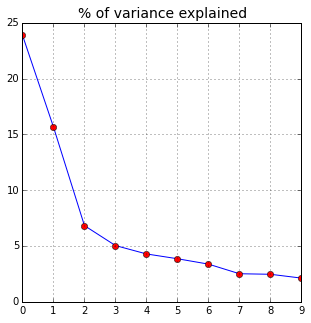

In [36]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

<br>
### keep number of PC sufficient to explain 70 % of the original variance 

In [37]:
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.70)[0][0]

In [38]:
ipc

9

<br>
### The Principal Components (PCs) are obtained by using the `transform` method of the `pca` object (`skpca`)

In [39]:
PCs = skpca.transform(X)

In [40]:
PCs = PCs[:,:ipc]

<br>
### The Empirical Orthogonal Functions (EOFs) are contained in the `components_` attribute of the `pca` object (`skpca`)

In [41]:
EOFs = skpca.components_

In [42]:
EOFs = EOFs[:ipc,:]

In [43]:
EOFs.shape

(9, 3133)

<br>
### we can the reconstruct the 2D fields (maps)

In [44]:
EOF_recons = np.ones((ipc, len(lat) * len(lon))) * -999.

In [45]:
for i in range(ipc): 
    EOF_recons[i,ocean] = EOFs[i,:]

In [46]:
EOF_recons = ma.masked_values(np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F'), -999.)

In [47]:
EOF_recons.shape

(9, 41, 86)

In [48]:
m = bm(projection='cyl',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
            llcrnrlon=lon.min(),urcrnrlon=lon.max(),\
            lat_ts=0,resolution='c')

In [49]:
type(EOF_recons)

numpy.ma.core.MaskedArray

In [50]:
EOF_recons *= 100

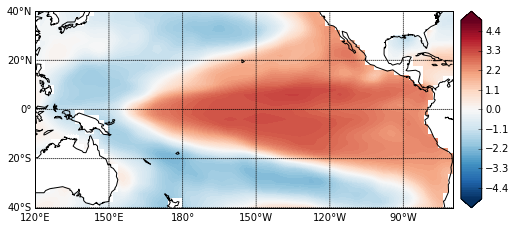

In [51]:
plot_field(m, EOF_recons[0,:,:], lats, lons, -5, 5, 0.1, grid=True, cmap=plt.get_cmap('RdBu_r'))

<br>
### scale the Principal Components

In [52]:
from sklearn.preprocessing import StandardScaler

In [53]:
scaler_PCs = StandardScaler()

In [54]:
scaler_PCs.fit(PCs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [55]:
PCs_std = scaler_PCs.transform(PCs)

In [56]:
joblib.dump(scaler_PCs, './scaler_PCs.pkl')

['./scaler_PCs.pkl', './scaler_PCs.pkl_01.npy', './scaler_PCs.pkl_02.npy']

In [57]:
PCdf = pd.DataFrame(PCs_std, index = dsub['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])

In [58]:
PCdf.head()

,EOF1,EOF2,EOF3,EOF4,EOF5,EOF6,EOF7,EOF8,EOF9
time,,,,,,,,,
1950-01-15,-1.123907,-1.755836,-0.452906,-0.712406,2.069823,-2.100420,0.717192,-0.657735,0.274798
1950-02-15,-1.249496,-1.710119,-0.638251,-0.524621,1.085331,-2.025163,-0.233940,-0.988423,0.049161
1950-03-15,-1.092109,-1.315710,-0.655874,0.620964,1.108923,-0.767232,-0.514578,-1.483388,0.898097
1950-04-15,-1.212728,-1.132280,-0.407089,0.413160,0.271240,-0.201163,-0.498882,-0.545291,1.621271
1950-05-15,-1.616118,-1.008179,-0.620920,-0.114747,0.097757,0.207640,-1.446340,-1.372091,1.284412


In [59]:
PCdf.to_csv('./EOF_ERSST_PCs.csv')

In [60]:
from scipy.signal import detrend

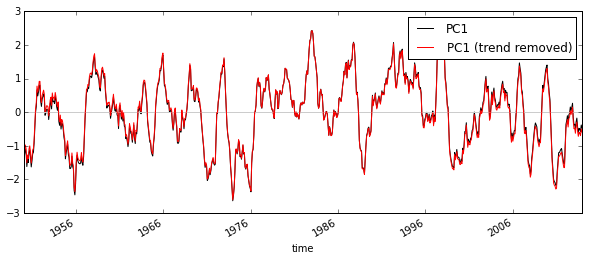

In [62]:
f, ax = plt.subplots(figsize=(10,4))
PCdf.ix[:,0].plot(ax=ax, color='k', label='PC1')
ax.axhline(0, c='0.8')
#ax.set_xlabel('period', fontsize=18)
ax.plot(PCdf.index, detrend(PCdf.ix[:,0].values), 'r',  label='PC1 (trend removed)')
ax.grid('off')
ax.legend(loc=1); 